# **Advanced_NLP_model**

### **Text Classification with Hugging Face Transformers**

In [40]:
from google.colab import files
uploaded = files.upload()

Saving all.csv to all (1).csv


In [41]:
import pandas as pd
import io

df = pd.read_csv(io.BytesIO(uploaded['all.csv']))

In [42]:
print("There are {} text samples with its corresponding emotions in the data set".format(len(df)))
print("---------------------------------------------------------------------------------------------------------")
df.head()

There are 20000 text samples with its corresponding emotions in the data set
---------------------------------------------------------------------------------------------------------


,feature,label
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


## **Plot the number of samples per emotion**

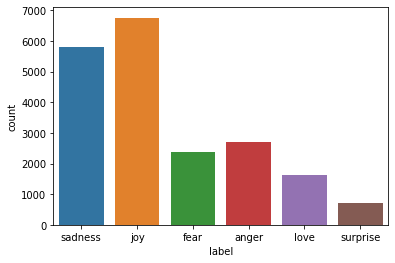

In [43]:
import seaborn as sns

sns.countplot(x='label',data=df)

### **Processing the text by removing noices**

In [44]:
pip install neattext

In [45]:
import neattext.functions as nfx

def neat_text(x):
  x['neat_text'] = x['feature'].apply(nfx.remove_userhandles)
  x['neat_text'] = x['neat_text'].apply(nfx.remove_punctuations)

neat_text(df)

In [46]:
df.head()

,feature,label,neat_text
0,im feeling rather rotten so im not very ambiti...,sadness,im feeling rather rotten so im not very ambiti...
1,im updating my blog because i feel shitty,sadness,im updating my blog because i feel shitty
2,i never make her separate from me because i do...,sadness,i never make her separate from me because i do...
3,i left with my bouquet of red and yellow tulip...,joy,i left with my bouquet of red and yellow tulip...
4,i was feeling a little vain when i did this one,sadness,i was feeling a little vain when i did this one


In [ ]:
pip install ktrain

In [48]:
import ktrain
from ktrain import text

In [49]:
cat = df['label'].unique().tolist()
cat

['sadness', 'joy', 'fear', 'anger', 'love', 'surprise']

## **Load the dataset**


In [50]:
X = df['neat_text']
Y = df['label']

In [51]:
X_data=[]
Y_data=[]
for i in range(len(X)):
  x = X[i]
  y = Y[i]
  Y_data.append(y)
  X_data.append(x)

In [52]:
from sklearn.model_selection import train_test_split

In [53]:
import numpy as np

np.random.seed(1)

## **Train-Test Splitting**

In [54]:
X_train,X_test,Y_train,Y_test = train_test_split(X_data,Y_data,test_size=0.2)

In [55]:
len(X_train),len(X_test)

(16000, 4000)

## **Model**

In [56]:
name = 'distilbert-base-uncased'
transformer = text.Transformer(name,maxlen=512)

## **Pre-Processing Text Inputs**

In [57]:
train = transformer.preprocess_train(X_train,Y_train)
test = transformer.preprocess_test(X_test,Y_test)

preprocessing train...
language: en
train sequence lengths:
	mean : 19
	95percentile : 41
	99percentile : 52


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 19
	95percentile : 41
	99percentile : 53


In [60]:
model = transformer.get_classifier()

In [61]:
learner = ktrain.get_learner(model,train_data=train,val_data=test,batch_size=16)

## **Obtain the best learning rate**

simulating training for different learning rates... this may take a few moments...
Epoch 1/5
1000/1000 [==============================] - 1711s 2s/step - loss: 1.6421 - accuracy: 0.3359
Epoch 2/5
1000/1000 [==============================] - 1698s 2s/step - loss: 0.5030 - accuracy: 0.8364
Epoch 3/5
1000/1000 [==============================] - 1694s 2s/step - loss: 1.2440 - accuracy: 0.5021
Epoch 4/5
1000/1000 [==============================] - 1363s 1s/step - loss: 7.7440 - accuracy: 0.3263


done.
Visually inspect loss plot and select learning rate associated with falling loss


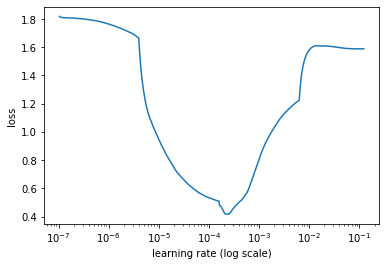

In [62]:
learner.lr_find(start_lr=1e-07, show_plot=True,max_epochs=5,stop_factor=4,verbose=1)

**From the graph, it is observed that the loss is minimum when the learning rate is around 1e-4.**

Hence, we fit the model with lr = 1e-4 

### **Fit the Model**

The one cycle and cyclic momentum seems to allow model to be trained on higher learning rates and converge faster. The one cycle policy provides some form of regularisation.

In [64]:
learner.fit_onecycle(1e-4,4)



begin training using onecycle policy with max lr of 0.0001...
Epoch 1/4
1000/1000 [==============================] - 1717s 2s/step - loss: 0.3929 - accuracy: 0.8702 - val_loss: 0.1868 - val_accuracy: 0.9302
Epoch 2/4
1000/1000 [==============================] - 1731s 2s/step - loss: 0.1925 - accuracy: 0.9243 - val_loss: 0.1796 - val_accuracy: 0.9270
Epoch 3/4
1000/1000 [==============================] - 1728s 2s/step - loss: 0.1389 - accuracy: 0.9371 - val_loss: 0.1573 - val_accuracy: 0.9300
Epoch 4/4
1000/1000 [==============================] - 1719s 2s/step - loss: 0.0797 - accuracy: 0.9616 - val_loss: 0.1457 - val_accuracy: 0.9333


## **Classification Report and Confusion Matrix**

In [65]:
learner.validate()

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       529
           1       0.89      0.93      0.91       475
           2       0.93      0.97      0.95      1343
           3       0.92      0.77      0.83       356
           4       0.96      0.97      0.97      1146
           5       0.86      0.70      0.77       151

    accuracy                           0.93      4000
   macro avg       0.92      0.88      0.90      4000
weighted avg       0.93      0.93      0.93      4000



array([[ 503,    6,    2,    0,   17,    1],
       [  13,  443,    3,    0,   16,    0],
       [   1,    5, 1297,   24,    5,   11],
       [   4,    0,   75,  273,    3,    1],
       [  20,    6,    4,    1, 1111,    4],
       [   0,   38,    7,    0,    0,  106]])

### **Accuracy = 93%**

In [66]:
pip install git+https://github.com/amaiya/eli5@tfkeras_0_10_1

# **Predicting Live Samples**

In [68]:
def predict_emotion(text):
  p = ktrain.get_predictor(learner.model,preproc=trans) 
  pred = p.predict(text)
  pred_score = np.max(p.predict_proba(text))
  print("Predicted Emotion: {}".format(pred))
  print("---------------------------------------------------------------------------")
  return p.explain(text)

### **Sample Text 1**


In [69]:
predict_emotion("I am frustrated at the way things are.")

Predicted Emotion: anger
---------------------------------------------------------------------------


### **Sample Text 2**


In [70]:
predict_emotion("Thank you! This is the best thing I can ask for.")

Predicted Emotion: joy
---------------------------------------------------------------------------


### **Sample Text 3**


In [71]:
predict_emotion("I am really scared of a spider")

Predicted Emotion: fear
---------------------------------------------------------------------------
